# PMR3404 - Controle I
# Projeto Final (Ball on Wheel)

#### Bruno Fernandes Maione (10770631)
#### Victor Kowalski Martins (10770482)

#### Professores:

#### Julho 2021

In [1]:
# Aqui importamos todas as bibliotecas que serão utilizadas no projeto

from sympy import *
from grafico_margens import plot_margins
import warnings
init_printing(use_unicode=True)
warnings.filterwarnings('ignore')
import control.matlab as co
import matplotlib.pyplot as plt
import numpy as np

### 1. Introdução

O primeiro passo a ser efetuado para o presente projeto é a definição e simplificação das equações de movimento, que deverão ser analisadas para uma futura construção do diagrama de blocos de nossa planta.

Como trabalharemos com ângulos pequenos e, principalmente, para possibilitar as transformadas de laplace posteriores, será utilizada a seguinte aproximação para os senos:

$$
sin(x) = x
$$

Tal aproximação, adaptada do primeiro limite fundamental do Cálculo, funciona para ângulos menores de 14º com erro de menor de 1%, o que se trata de uma precisão perfeitamente satisfatória para o projeto.

In [2]:
# Definindo as equações de movimento

t = symbols('t')
s = symbols('s')
m = symbols('m')
r = symbols('r')
R = symbols('R')
g = symbols('g')
v = symbols('vartheta')
O = symbols('Theta')
n = symbols('n')
Kt = symbols('K_t')
Kv = symbols('K_v')
Lm = symbols('L_m')
Rm = symbols('R_m')
T = symbols('Gamma')
# T = O*v + m*(v*(R**2) + O*(r**2))

y, psi, chi, u, i, V = symbols('y, psi, chi, u, i, V', cls=Function)

y = y(t)
y_dot = y.diff()
y_ddot = y_dot.diff()

psi = psi(t)
psi_dot = psi.diff()
psi_ddot = psi_dot.diff()

chi = chi(t)
chi_dot = chi.diff()
chi_ddot = chi_dot.diff()

u = u(t)
u_dot = u.diff()
u_ddot = u_dot.diff()

i = i(t)
i_dot = i.diff()
i_ddot = i_dot.diff()

V = V(t)
V_dot = V.diff()
V_ddot = V_dot.diff()

eq_y = Eq(y ,(R+r)*chi)
eq_psi_ddot = Eq(psi_ddot ,((m*(r**2) + v)*u + m*g*R*v*chi)/T)
eq_chi_ddot = Eq(chi_ddot ,(v*R*u + (O*(r**2) + v*(R**2))*m*g*chi)/(T*(r+R)))
eq_u = Eq(u ,n*Kt*i)
eq_V = Eq(V, Lm*i_dot + Rm*i + Kv*psi_dot)

Uma vez com as equações definidas no código, podemos realizar as manipulações no domínio da frequência, com as transformadas de laplace.

Como a biblioteca Sympy no Python não tem suporte nativo para transformadas de laplace com derivadas e integrais, devemos definir uma função (que aproveite o básico da bilbioteca nativa) para abrangir tais funcionalidades e possibilite o uso ao longo das deduções, uma vez que essas peculiaridades com certeza seriam utilizadas.

In [3]:
def laplace_completa(e, t, s):
    """
        Função completa adaptada da transformada de laplace, acrescido do suporte à derivadas e integrais.
        Adaptada de: https://github.com/sympy/sympy/issues/7219#issuecomment-154768904

        Parâmetros
            Inputs: e (expressão simbólica à ser transformada), t (simbólico que representa o tempo), s (simbólico que representa o s de nossa transformada)
            Outputs: res (expressão simbólica após a transformada)
    """

    res = laplace_transform(e, t, s, noconds=True)
    wf = Wild('f')
    lw = LaplaceTransform(wf, t, s)

    for exp in res.find(lw):
        e = exp.match(lw)[wf]
        args = e.args

        if isinstance(e, Derivative):
            # for derivative check that there's only d/dt^n with n>0
            if len(args) == 2 and args[1][0] == t:
                n = args[1][1]
                if n > 0:
                    newexp = s**n * LaplaceTransform(e.args[0], t, s)
                res = res.replace(exp, newexp)

        elif isinstance(e, Integral):
            # for integral check that there's only n consecutive indefinite integrals w.r.t. t
            if all(len(arg) == 1 and arg[0] == t for arg in args[1:]):
                newexp = s**(-len(args[1:])) * LaplaceTransform(args[0], t, s)
                res = res.replace(exp, newexp)

        # caso não tenha derivada ou integral, segue sem entrar nos ifs

    return res

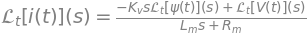

In [4]:
i_s = laplace_completa(i, t, s)
eq_i_s = Eq(i_s, solve(Eq(laplace_completa(eq_V.lhs,t,s), laplace_completa(eq_V.rhs,t,s)), i_s)[0])
eq_i_s

In [5]:
u_s = laplace_completa(u, t, s)
eq_u_s = Eq(u_s, solve(Eq(laplace_completa(eq_u.lhs,t,s), laplace_completa(eq_u.rhs,t,s)), u_s)[0])
eq_u_s

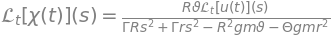

In [6]:
chi_s = laplace_completa(chi, t, s)
eq_chi_s = Eq(chi_s, solve(Eq(laplace_completa(eq_chi_ddot.lhs,t,s), laplace_completa(eq_chi_ddot.rhs,t,s)), chi_s)[0]).simplify()
eq_chi_s

In [26]:
print(latex(eq_chi_s.rhs))

\frac{R \vartheta \mathcal{L}_{t}\left[u{\left(t \right)}\right]\left(s\right)}{\Gamma R s^{2} + \Gamma r s^{2} - R^{2} g m \vartheta - \Theta g m r^{2}}


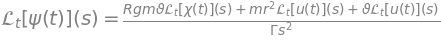

In [7]:
psi_s = laplace_completa(psi, t, s)
eq_psi_s = Eq(psi_s, solve(Eq(laplace_completa(eq_psi_ddot.lhs,t,s), laplace_completa(eq_psi_ddot.rhs,t,s)), psi_s)[0])
eq_psi_s

In [8]:
y_s = laplace_completa(y, t, s)
eq_y_s = Eq(y_s, solve(Eq(laplace_completa(eq_y.lhs,t,s), laplace_completa(eq_y.rhs,t,s)), y_s)[0])
eq_y_s

Com as expressões tranformadas para o domínio da frequência, podemos contruir o diagrama de blocos (em malha aberta) de nosso sistema.

![Picture title](image-20210722-195147.png)


Chama-se $$\frac{R\vartheta}{R^3ms^2\vartheta-R^2mg\vartheta+R^2mrs^2\vartheta+R\Theta mr^2s^2+R\Theta s^2\vartheta-\Theta mgr^2+\Theta mr^3s^2 + \Theta rs^2\vartheta}$$ de $$G_1(s)$$ e pode-se simplificar o diagrama de blocos da seguinte forma:

![Picture title](db-simplificado.png)


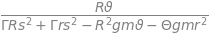

In [9]:
G1 = eq_chi_s.rhs/u_s
G1.simplify()

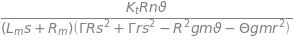

In [10]:
Gcima = ((Kt*n)/(Lm*s+Rm)*G1).simplify()
Gcima

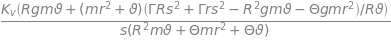

In [11]:
Gbaixo = ((R*g*m*v + (m*r**2+v)/G1)*(Kv*s)/(s**2*(R**2*m*v + O*m*r**2 + O*v)))
Gbaixo

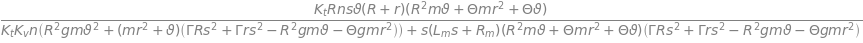

In [12]:
Gfinal = (Gcima/(1+Gcima*Gbaixo)*(R+r)).simplify()
Gfinal

![Picture title](image-20210722-222358.png)

Fechando a malha e inserindo controladores de cascata, temos o diagrama final apresentado abaixo.

![Picture title](db-cascata.png)

Repare que agora será necessário dimensionar e projetar nossos controladores, para posteriormente fazermos teste com distúrbios no torque da roda, parâmetro físico mais interessante na presente problemática.

In [13]:
Gp = s*Gfinal

In [14]:
print_python(Gp)

K_t = Symbol('K_t')
R = Symbol('R')
n = Symbol('n')
s = Symbol('s')
vartheta = Symbol('vartheta')
r = Symbol('r')
m = Symbol('m')
Theta = Symbol('Theta')
K_v = Symbol('K_v')
g = Symbol('g')
Gamma = Symbol('Gamma')
L_m = Symbol('L_m')
R_m = Symbol('R_m')
e = K_t*R*n*s**2*vartheta*(R + r)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)/(K_t*K_v*n*(R**2*g*m*vartheta**2 + (m*r**2 + vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2)) + s*(L_m*s + R_m)*(R**2*m*vartheta + Theta*m*r**2 + Theta*vartheta)*(Gamma*R*s**2 + Gamma*r*s**2 - R**2*g*m*vartheta - Theta*g*m*r**2))


In [15]:
s = co.tf("s")

Theta = 0.028 # kg.m^2
R = 0.16 # m
m = 0.048 # kg
vartheta = 2.54*10e-5 #kg.m^2
r = 0.0296 #m
K_t = 0.1604 # N.m/A
K_v = 0.1186 # V.s/rad
R_m = 12 # ohm
L_m = 1.16 # mH
g = 9.8 # m/s^2
n = 40

Gp = K_t*R*n*s**2*vartheta*(R + r)/(K_t*K_v*n*(R*m*r**2*s**2 + R*s**2*vartheta - g*m*r**2 + m*r**3*s**2 + r*s**2*vartheta) + s*(L_m*s + R_m)*(R**3*m*s**2*vartheta - R**2*g*m*vartheta + R**2*m*r*s**2*vartheta + R*Theta*m*r**2*s**2 + R*Theta*s**2*vartheta - Theta*g*m*r**2 + Theta*m*r**3*s**2 + Theta*r*s**2*vartheta))

In [16]:
p_g = co.pole(Gp)
z_g = co.zero(Gp)
print(p_g, z_g)

[-6.97853781  2.89038017 -4.38046068 -1.87620926] [0. 0.]


In [17]:
# ess_des = x # erro desejado
# Kc = sp.symbols('Kc')

# Erro degrau inicial
Kp = co.evalfr(Gp, 0)
ess = 1/(1 + Kp)
Kp

# Calculo do Kc
# eq_Kc = (1/(1 + Kc*Kp) - ess_des)
# Kc = float(sp.solve(eq_Kc)[0])

(-0-0j)

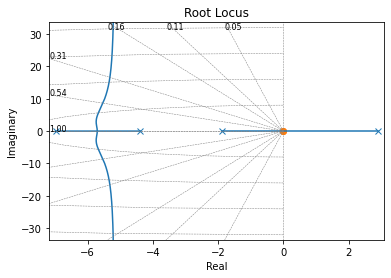

In [18]:
co.rlocus(Gp)
pass

In [19]:
t = np.linspace(0, 4, 10000)
# impulso = np.zeros(len(t))
# impulso[len(t)//10] = 0.01
entrada = np.ones(len(t))*10

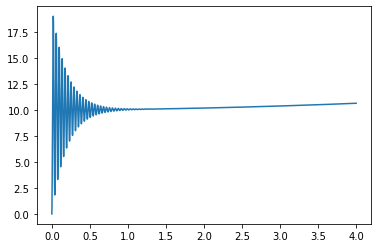

In [20]:
# y , t = co.step(1*Gp)
y, t, xout = co.lsim(co.feedback(1000*Gp,1), entrada, t)
plt.figure()
plt.plot(t,y)

In [21]:
co.damp(co.feedback(1000*Gp,1))

_____Eigenvalue______ Damping___ Frequency_
    -5.174    +161.6j      0.032      161.7
    -5.174    -161.6j      0.032      161.7
   0.08142                     1   -0.08142
  -0.07788                     1    0.07788


(array([1.61697049e+02, 1.61697049e+02, 8.14158645e-02, 7.78766466e-02]),
 array([ 0.03199924,  0.03199924, -1.        ,  1.        ]),
 array([-5.1741834 +161.61424232j, -5.1741834 -161.61424232j,
         0.08141586  +0.j        , -0.07787665  +0.j        ]))

In [22]:
print(co.stepinfo(co.feedback(Gp)))

{'RiseTime': 0.0, 'SettlingTime': nan, 'SettlingMin': 0.0, 'SettlingMax': 57100.50768376207, 'Overshoot': 0, 'Undershoot': 0, 'Peak': 57100.50768376207, 'PeakTime': 5.365926839086951, 'SteadyStateValue': -0.0}


(inf, 3.667509555143397, nan, 161.53136338590443)

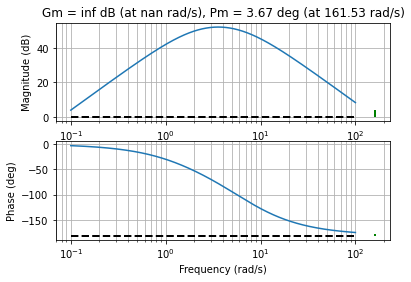

In [23]:
plot_margins(1000*Gp)

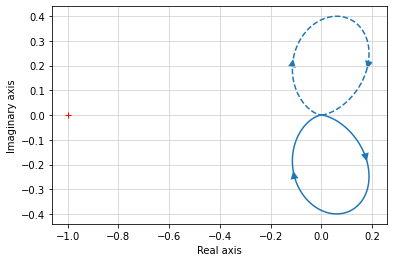

In [24]:
co.nyquist(Gp)
pass

### 3. Discussões

### 4. Conclusões

![Picture title](image-20210722-231355.png)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4b5d483-a464-4b27-a020-25b9883aaa56' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>